# Import Statements

In [ ]:

import collections
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization
import tensorflow_datasets as tfds
!pip install tensorflow-text
import tensorflow_text as tf_text
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


AttributeError: ignored

In [ ]:

# Helper function for plotting

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Preprocessing Data for use with RNN

In [ ]:
data_url = 'https://storage.googleapis.com/heyheyeheyeh/FinalAmazon.zip'
# Data is efficiently stored on a public google cloud account
dataset_dir = utils.get_file(
    origin=data_url,
    extract =True,
    cache_dir='datasets',
    cache_subdir=''
    )

dataset_dir = pathlib.Path(dataset_dir).parent

667801/667801 [==============================] - 0s 0us/step


In [ ]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/FinalAmazon.zip'),
 PosixPath('/tmp/.keras/FinalAmazon'),
 PosixPath('/tmp/.keras/__MACOSX')]

In [ ]:
# Extracting training data
train_dir = dataset_dir/'FinalAmazon'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/FinalAmazon/Negative '),
 PosixPath('/tmp/.keras/FinalAmazon/Positive')]

In [ ]:
# The size of each batch of data
batch_size = 32
# Random seed
seed = 42

In [ ]:
# Keras method to make a text dataset - First creating train and test sets
(raw_train_ds, raw_test_ds) = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='both',
    seed=seed)
# Then creating validation set
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)


Found 1000 files belonging to 2 classes.
Using 800 files for training.
Using 200 files for validation.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.


Since text data is of varying lengths, we need to normalize the lengths in order to design a neural network that can take our text data as an input. One way to do this is Text Vectorization, which takes text data and turns it into a sequence of integers of equal size. Here, we will turn our text data into a set of binary integers that maps to our text data

Keras has a conveninet function that does this by:

1. Standardizing each example (lowercasing + punctuation stripping)
2. Splitting each example into substrings (usually words)
3. Recombining substrings into tokens (usually ngrams)
4. Index tokens (associate a unique int value with each token)
5. Transform each example using this index, either into a vector of ints or a dense float vector.

We specify the vocab size as 10000, this repsents the maximum amount of words

In [ ]:
VOCAB_SIZE = 10000
binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

In [ ]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
  #  output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)


In [ ]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:

def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", first_label)


Question tf.Tensor(b'It finds my cell phone right away when I enter the car.\n', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
print("'int' vectorized question:",
      int_vectorize_text(first_question, first_label)[0])

'int' vectorized question: tf.Tensor(
[[   5 1332   11  142   10  159  330   61    4 1368    2   88    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0

In [ ]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  gimmick
313 --->  family
Vocabulary size: 1652


In [ ]:


int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

# Traing a Recurrent Neural Network Model

In [ ]:
# Keras makes it easy to train an RNN with an LSTM unit that helps improve text data processing.
# Essesntially, LSTM provides a level of memory and context to data processed in the network
def create_model(vocab_size, num_labels):
  model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 64, mask_zero=True),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(364,  return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      layers.Dense(64, activation='relu'),
      layers.Dense(num_labels),
  ])
  return model

In [ ]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=1)
int_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
history = int_model.fit(int_train_ds, validation_data=int_val_ds, epochs=10)

Epoch 1/10
25/25 [==============================] - 30s 376ms/step - loss: 0.6848 - accuracy: 0.4988 - val_loss: 0.6493 - val_accuracy: 0.5100
Epoch 2/10
25/25 [==============================] - 1s 26ms/step - loss: 0.4674 - accuracy: 0.7475 - val_loss: 0.6404 - val_accuracy: 0.8000
Epoch 3/10
25/25 [==============================] - 1s 24ms/step - loss: 0.2167 - accuracy: 0.9300 - val_loss: 0.5645 - val_accuracy: 0.8200
Epoch 4/10
25/25 [==============================] - 1s 24ms/step - loss: 0.1390 - accuracy: 0.9563 - val_loss: 0.5586 - val_accuracy: 0.8400
Epoch 5/10
25/25 [==============================] - 1s 25ms/step - loss: 0.1201 - accuracy: 0.9663 - val_loss: 0.5214 - val_accuracy: 0.8300
Epoch 6/10
25/25 [==============================] - 1s 25ms/step - loss: 0.0511 - accuracy: 0.9912 - val_loss: 0.5832 - val_accuracy: 0.8550
Epoch 7/10
25/25 [==============================] - 1s 25ms/step - loss: 0.0314 - accuracy: 0.9925 - val_loss: 0.5394 - val_accuracy: 0.8350
Epoch 8/10


In [ ]:
print("RNN model on int vectorized data:")
print(int_model.summary())

RNN model on int vectorized data:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 bidirectional (Bidirectiona  (None, None, 728)        1249248   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               194816    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,088,35

In [ ]:

int_loss, int_accuracy = int_model.evaluate(int_train_ds)
int_loss2, int_accuracy2 = int_model.evaluate(int_val_ds)
int_loss3, int_accuracy3 = int_model.evaluate(int_test_ds)

print("Int TRAIN model accuracy: {:2.2%}".format(int_accuracy))
print("Int VAL model accuracy: {:2.2%}".format(int_accuracy2))
print("Int TEST model accuracy: {:2.2%}".format(int_accuracy3))

7/7 [==============================] - 0s 11ms/step - loss: 0.8679 - accuracy: 0.8400
Int TRAIN model accuracy: 99.87%
Int VAL model accuracy: 84.00%
Int TEST model accuracy: 84.00%


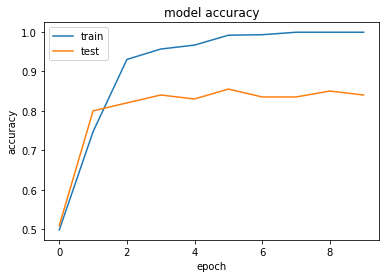

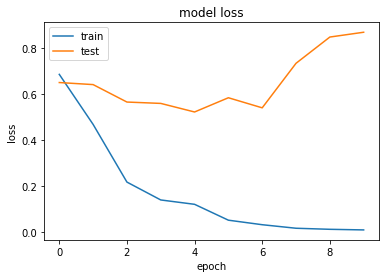

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
## probability_model = tf.keras.Sequential([int_model,
  #                                       tf.keras.layers.Sigmoid()])

text_batch, label_batch = int_test_ds.as_numpy_iterator().next()
predictions = int_model.predict_on_batch(text_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
#print(predictions)

In [ ]:
#for i in iteritems:
 # print("-----------------------------------")
  #print("Actual: " + str(label_batch[i]) )
  #print("Predicted: " + str(predictions.numpy()[i][0]))

In [ ]:
print(label_batch[5])

pred = predictions.numpy()
print(pred[5][0])

print(raw_test_ds.element_spec)
mapp = {0: 'Negative Sentiment', 1: 'Positive Sentiment'}

text_actual, label_actual = raw_test_ds.as_numpy_iterator().next()
label_batch = np.vectorize(mapp.get)(label_batch)
pred = np.vectorize(mapp.get)(pred)

0
1
(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
print("-----------------")
print("The following sentence was misclassified:")
print()
print(text_actual[5].strip())
print()
print("Actual: " + str(label_batch[5]) )
print("Predicted: " + str(pred[5][0]) )
print()
#############
print("-----------------")
print("The following sentence was misclassified:")
print()
print(text_actual[19].strip())
print()
print("Actual: " + str(label_batch[19]) )
print("Predicted: " + str(pred[19][0]) )
print()
#############
print("-----------------")
print("The following sentence was misclassified:")
print()
print(text_actual[24].strip())
print()
print("Actual: " + str(label_batch[24]) )
print("Predicted: " + str(pred[24][0]) )
print()

-----------------
The following sentence was misclassified:

b'The earpiece on this is too large or too heavy...it keeps falling out of my ear.'

Actual: Negative Sentiment
Predicted: Positive Sentiment

-----------------
The following sentence was misclassified:

b"This is hands down the best phone I've ever had."

Actual: Positive Sentiment
Predicted: Negative Sentiment

-----------------
The following sentence was misclassified:

b'In my house I was getting dropped coverage upstairs and no coverage in my basement.'

Actual: Negative Sentiment
Predicted: Positive Sentiment



I ran out of errors in the test data set, so we will next look at the validation set

In [ ]:
text_batch, label_batch = int_val_ds.as_numpy_iterator().next()
predictions = int_model.predict_on_batch(text_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

label_batch[10]

0

In [ ]:
#for i in range(0,len(label_batch)):
 # print("-----------------------------------")
  #print("Actual: " + str(label_batch[i]) )
 # print("Predicted: " + str(predictions.numpy()[i][0]))

In [ ]:
print(label_batch[5])

pred = predictions.numpy()
print(pred[5][0])

print(raw_test_ds.element_spec)
mapp = {0: 'Negative Sentiment', 1: 'Positive Sentiment'}

text_actual, label_actual = raw_val_ds.as_numpy_iterator().next()
label_batch = np.vectorize(mapp.get)(label_batch)
pred = np.vectorize(mapp.get)(pred)

0
0
(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
print("-----------------")
print("The following sentence was misclassified:")
print()
print(text_actual[4].strip())
print()
print("Actual: " + str(label_batch[4]) )
print("Predicted: " + str(pred[4][0]) )
print()
#############
print("-----------------")
print("The following sentence was misclassified:")
print()
print(text_actual[10].strip())
print()
print("Actual: " + str(label_batch[10]) )
print("Predicted: " + str(pred[10][0]) )
print()
#############
print("-----------------")
print("The following sentence was misclassified:")
print()
print(text_actual[19].strip())
print()
print("Actual: " + str(label_batch[19]) )
print("Predicted: " + str(pred[19][0]) )
print()
#############

-----------------
The following sentence was misclassified:

b'I plugged it in only to find out not a darn thing worked.'

Actual: Negative Sentiment
Predicted: Positive Sentiment

-----------------
The following sentence was misclassified:

b'I am going to have to be the first to negatively review this product.'

Actual: Negative Sentiment
Predicted: Positive Sentiment

-----------------
The following sentence was misclassified:

b'We received a WHITE colored battery that goes DEAD after a couple hoursTHe original used to last a week - but still lasts longer than thereplacement'

Actual: Positive Sentiment
Predicted: Negative Sentiment

